# GARCH

This notebook contains the results of voltality forecasting with GARCH and a few of it's variants on S&P500 returns.
1. GARCH(1,1) <-- would be nice to also have a method of moments implementation
2. EGARCH(1,1)
3. GJR-GARCH(1,1,1)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis
from arch import arch_model

In [2]:
# data read in, adjustment and conversion to returns
sp500_data = pd.read_csv("./data/sp500index.csv")
sp500_data.index = sp500_data["Date"].astype('datetime64[ns]')
sp500_data.drop(columns=['Date'],inplace=True)

# convert to returns and normalize returns
sp500_returns = sp500_data['Close'].pct_change()[1:]
sp500_returns = (sp500_returns - np.mean(sp500_returns))/np.std(sp500_returns) # normalize to have mean 0 std 1

## S&P 500 Returns Exploration

In [3]:
# testing kurtosis functions
scipy_kurtosis = kurtosis(sp500_returns, fisher=False)
print("Scipy version:", scipy_kurtosis)

Scipy version: 23.849598711166028


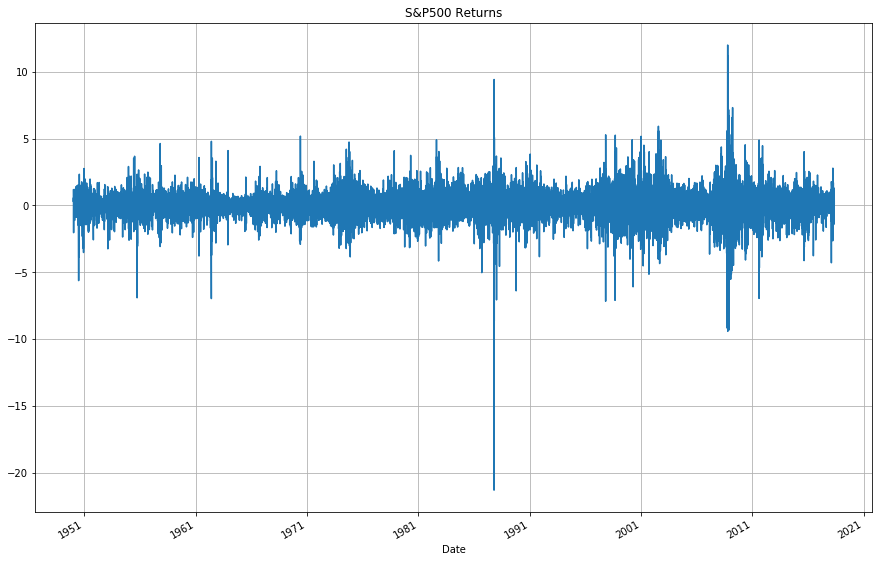

In [4]:
sp500_returns.plot(title='S&P500 Returns',grid=True, figsize=(15, 10));

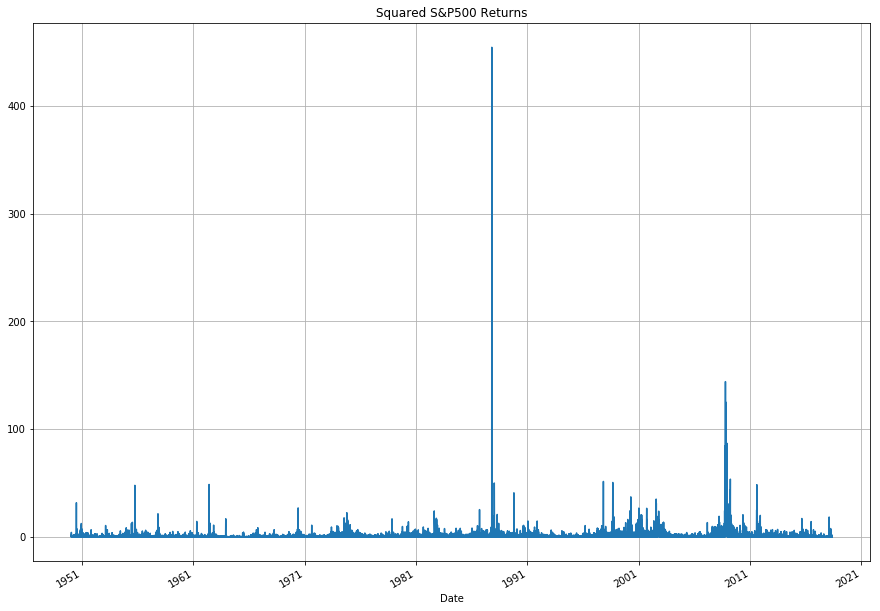

In [5]:
squaredreturns = sp500_returns**2
squaredreturns.plot(title = "Squared S&P500 Returns", grid=True, figsize=(15,11));

## GARCH(1,1) with arch package

In [6]:
garch_11 = arch_model(sp500_returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = garch_11.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 21235.81956272471
Iteration:      2,   Func. Count:     17,   Neg. LLF: 21229.262767422362
Iteration:      3,   Func. Count:     26,   Neg. LLF: 21228.54788539144
Iteration:      4,   Func. Count:     33,   Neg. LLF: 21215.962685119513
Iteration:      5,   Func. Count:     42,   Neg. LLF: 21215.855373764283
Iteration:      6,   Func. Count:     49,   Neg. LLF: 21205.095798443264
Iteration:      7,   Func. Count:     57,   Neg. LLF: 21205.024421251812
Iteration:      8,   Func. Count:     64,   Neg. LLF: 21204.67664782551
Iteration:      9,   Func. Count:     70,   Neg. LLF: 21204.59514354018
Iteration:     10,   Func. Count:     76,   Neg. LLF: 21204.591491878175
Iteration:     11,   Func. Count:     82,   Neg. LLF: 21204.59144147815
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 21204.591440586333
            Iterations: 11
            Function evaluations: 83
            Gradient evaluat

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -21204.6
Distribution:                  Normal   AIC:                           42417.2
Method:            Maximum Likelihood   BIC:                           42448.2
                                        No. Observations:                17200
Date:                Sun, May 27 2018   Df Residuals:                    17196
Time:                        13:07:44   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0181  6.477e-03      2.797  5.150e-03 [5.424e-03,3.081e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.7934e-03  1.964e-03      4.985  6.184e-07 [5.943e-03,1.364e-02]
alpha[1]       0.0840  1.091e-02      7.703  1.329e-14   [6.266e-02,  0.105]
beta[1]        0.9078  1.116e-02     81.367      0.000     [  0.886,  0.930]
============================================================================

Covariance estimator: robust
"""

In [68]:
C, A, B = res.params[1:] # store GARCH coefficients

## GARCH(1,1) - implemented myself

In [7]:
# Here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

In [8]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

Now we perform numerical optimization to find our estimate for $$\hat\theta = \arg \max_{(a_0, a_1, b_1)}\mathcal{L}(\theta) = \arg \min_{(a_0, a_1, b_1)}-\mathcal{L}(\theta)$$

We have some constraints on this

$$a_1 \geq 0, b_1 \geq 0, a_1+b_1 < 1$$

In [10]:
import cvxopt
from functools import partial
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

objective = partial(negative_log_likelihood, sp500_returns)

# Define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})

# Actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                        method='SLSQP',
                        constraints = cons)
theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


theta MLE: [0.00964486 0.08333816 0.90863022]


Thankfully the parameters calculated via MLE are identical to those calculated using the arch package so going forward we can rely on the arch package.

## $L_1$ prediction with GARCH(1,1)

Under the objective of $L_1$ optimal prediction, the optimal predictor is the conditional median - not the conditional expectation. Under an ARCH(p) model, the $L_1$ optimal predictor of $Y_{n+1}^2$ is given by

$$ Median(Y_{n+1}^2| \mathfrak{F_{n}}) = (a + \sum_{i=1}^{p} a_i Y_{n+1-i}^2)Median(Z_{n+1}^2) $$




In [94]:
def arch_p(C, A, B, returns, p):
    """returns sigma^2 term in ARCH(p) model using coefficients from fitted GARCH(1,1) model """

    squared_returns = returns**2
    lagged_squared_returns = squared_returns.iloc[-p:] # return last p elements of series
    lagged_squared_returns = lagged_squared_returns[::-1] # reverse the ordering of them

    a = C/(1-B)
    a_i = [A*B**(i-1) for i in range(1,p+1)]

    ans = a + np.dot(a_i,lagged_squared_returns)
    return ans

In [95]:
def garch_forecast(C, A, B, returns, dist='Normal'):
    """ L1 forecast for GARCH models
    input:
    C - constant term in GARCH model
    A - coeff for Y_n^2 term in GARCH model
    B - coeff for sigma_n^2 term in GARCH model
    """
    
    n = len(returns)
    p = int(n/2)
    
    # sigma^2 term in arch(p) model
    arch_p_term = arch_p(C, A, B, returns, p)
    
    # calculate median of error term squared
    if dist.lower()=='normal':
        Zn2 = 0.45
    elif dist.lower()=='t':
        Zn2 = 0.53
    else:
        print("Invalid distribution entered, only 'normal' or 't' allowed")
        return None
    
    forecast = arch_p_term * Zn2
    return forecast